In [1]:
import cv2
import pandas as pd
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
import os
from PIL import Image
import numpy as np
from IPython.display import Image
import torch
import PIL

data_dir = 'img' #내드라이브에 사진이 저장되어 있는 경로

x_data = []
y_data = []
files = []
dirs = os.listdir(data_dir) #dirs : 'clean.14.jpg'

for dir in dirs:
  file = os.path.join(data_dir, dir) #files : /content/drive/MyDrive/train/clean.14.jpg 전체경로
  files.append(file)

import torchvision.transforms as transforms
tf = transforms.ToTensor()
for file in files:
   image = PIL.Image.open(file)
   resize_image = image.resize((64,64))
   final_image = tf(resize_image) # 해주면 image의 shape는 (3,64,64) 이된다
   final_image = final_image.tolist()
   x_data.append(final_image)

x_data = torch.tensor(x_data)

for dir in dirs:
  if dir[:5] == 'clean':
    output = 0.0 #clean: 0
  else:
    output = 1.0  #pollution:1
  
  y_data.append(output)

y_data = torch.tensor(y_data)

In [4]:
x_data.shape

torch.Size([400, 3, 64, 64])

In [5]:
y_data.shape

torch.Size([400])

train,valid 분류

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 모델 정의

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(2304, 512) 
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1,2304)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [8]:
model = Net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 30

In [9]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

### model 학습

In [10]:

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i,data in enumerate(x_train, 0):
        optimizer.zero_grad()
        data = data
        labels = y_train

        outputs = model(data)

        #labels = labels.tolist()
        k = torch.tensor(labels[i])
        k = k.view(1,-1)
        #labels = labels.view(len(labels),-1)
        k = k
        #print(k.shape)
        #print(outputs.shape)
        loss = criterion(outputs, k)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, k)

        if i % 240 == 239:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 240, running_acc / 240))
            running_loss = 0.0

print("learning finish")

<ipython-input-10-29c3664ee992>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(labels[i])


epoch: [1/30] train_loss: 0.67433 train_acc: 57.50000
epoch: [2/30] train_loss: 0.37589 train_acc: 84.58334
epoch: [3/30] train_loss: 0.26186 train_acc: 90.00000
epoch: [4/30] train_loss: 0.23715 train_acc: 91.25000
epoch: [5/30] train_loss: 0.22544 train_acc: 90.83334
epoch: [6/30] train_loss: 0.21260 train_acc: 91.66666
epoch: [7/30] train_loss: 0.20086 train_acc: 92.50000
epoch: [8/30] train_loss: 0.19047 train_acc: 92.91666
epoch: [9/30] train_loss: 0.18103 train_acc: 93.75000
epoch: [10/30] train_loss: 0.17284 train_acc: 93.75000
epoch: [11/30] train_loss: 0.16558 train_acc: 94.16666
epoch: [12/30] train_loss: 0.15863 train_acc: 95.00000
epoch: [13/30] train_loss: 0.15232 train_acc: 95.41666
epoch: [14/30] train_loss: 0.14664 train_acc: 95.83334
epoch: [15/30] train_loss: 0.14186 train_acc: 95.83334
epoch: [16/30] train_loss: 0.13660 train_acc: 96.25000
epoch: [17/30] train_loss: 0.12912 train_acc: 95.83334
epoch: [18/30] train_loss: 0.12261 train_acc: 96.25000
epoch: [19/30] trai

### test 확인

In [11]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    data = x_test
    labels = y_test

    for i,data in enumerate(x_test, 0):
        data = data
        labels = y_test
        k = torch.tensor(labels[i])
        k = k.view(1,-1)
        outputs = model(data)
        acc = accuracy(outputs, k)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 89.87342 %
test finish!


<ipython-input-11-2ef9e872ed63>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(labels[i])


### detect

In [12]:
import cv2
import numpy as np
import torch

In [13]:
def predict(pred):
  pred = pred
  outputs = model(pred)
  pred_tag = torch.round(torch.sigmoid(outputs))
  return pred_tag

In [14]:
def predicts(pred):
  pred = pred
  outputs = model(pred)
  pred_tag = torch.sigmoid(outputs)
  return pred_tag

# 파이어베이스

In [15]:
from time import sleep
import datetime
import sys, os
import requests
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage
from firebase_admin import db
from uuid import uuid4

cred = credentials.Certificate("cg24-8875b-firebase-adminsdk-89mhn-99633286a5.json")
# firebase_admin.initialize_app(cred, {
#     'databaseURL':'https://cg24-8875b-default-rtdb.firebaseio.com/'  # database 주소 입력
# })

db_url= 'https://cg24-8875b-default-rtdb.firebaseio.com/'
default_app = firebase_admin.initialize_app(cred, {'databaseURL':db_url,'storageBucket':f"cg24-8875b.appspot.com" })
bucket = storage.bucket()

In [25]:
!pip install google-cloud-storage

In [1]:
pip install service_account

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement service_account (from versions: none)
ERROR: No matching distribution found for service_account


In [16]:
from google.cloud import storage
from google.oauth2 import service_account

In [17]:
import datetime

In [20]:
while True:
    #파이어베이스에서 1이라고 인식할 시
    ref1 = db.reference('barcode/barcode')
    ref = db.reference('barcode')

    #바코드 가지고 오는 코드
    row = ref1.get()
    #10이면 사진찍고 올린 상태임
    if (row == "10"):
        # 이미지 다운코드(되나 확인 부탁)
        credentials = service_account.Credentials.from_service_account_file("cg24-8875b-firebase-adminsdk-89mhn-99633286a5.json")
        x = datetime.datetime.now()
        file_name="cupimg "+x.strftime("%d %B %Y ")+x.strftime("%Hh %Mm %Ss")+'.jpg'
        storage.Client(credentials=credentials).bucket(firebase_admin.storage.bucket().name).blob('image_store/image.jpg').download_to_filename(file_name)

        
        #그 후 이미지 판별하는 코드

        image3 = PIL.Image.open(file_name)
        image3.save(file_name)
        area = (220,80,730,600)
        crop_img = image3.crop(area)
        crop_img.save(file_name)
        img3 =crop_img.resize((64,64))
        re_img3 = tf(img3) # 해주면 image의 shape는 (3,64,64) 이된다
        value = predict(re_img3)
        if value == 0: #깨끗하면
            percent = predicts(re_img3) 
            prediction = 400
            print(percent)
            percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
            print(percent_100)
        else: # 더러우면 
            percent = predicts(re_img3) 
            prediction = 200
            print(percent)
            percent_100 = percent[0][0]*100
            print(percent_100)
            
            
         # 현재 사용자 파악하기
        ref = db.reference("CG24/IDs/present_barcode")
        user_id = ref.get()        # 현재 사용자의 id
        print(user_id)

        # 현재까지 찍은 컵의 개수
        ref = db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/count")
        index_num = ref.get()
        print('index_num: ' ,index_num)
        
        
        
        
        # 컵의 개수 초기값
        if (index_num==None):
            dir=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/")
            dir.update({'count': 0})
        
            ref = db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/count")
            index_num = ref.get()
        
            print("if none:",index_num)

        index_str=str(index_num)
        
        
        # 컵 청결도 결과 저장하기
        dir=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/"+index_str)
        dir.update({'prediction': prediction})
        
        now = datetime.datetime.now()
        dir.update({'datetime': str(now.date())})      # 현재 날짜
        dir.update({'datetime2': str(x.strftime("%d %B %Y ")+x.strftime("%Hh %Mm %Ss"))})   # 현재 시간
        
        
        # 현재까지 prediction 값
        prediction_ref=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/point")
        old_prediction = prediction_ref.get()
        totoal_points=old_prediction
        
        
        #그냥 프린트 하는 값
        count = db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/point")
        total_point2 = count.get()


        
        #ref_pred=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/"+str(index_num-1)+"/prediction")
        ref_pred=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/"+str(index_num)+"/prediction")
        totoal_points=totoal_points+int(ref_pred.get())
    
        dir=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/")
        dir.update({'point': totoal_points})
        

        # 찍은 컵의 개수 +1
        index_num=index_num+1
        dir=db.reference("CG24/UserAccount/"+user_id+"/"+"cup/CupCount/")
        dir.update({'count': index_num})
        
        
        #이미지 판별 끝나고 더러우면  100으로, 깨끗하면 1000으로 바꿔주기(if, else)
        ref3 = db.reference('barcode')
        if prediction == 400 :
            
            ref3.update({'barcode':"1000"})
        else:
            ref3.update({'barcode':"100"})
            
        
        

    else : 
        continue
    sleep(1)

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor(100., grad_fn=<MulBackward0>)
JmHqQfTeAZebqKI0UCPM0Ytk2Pk2
index_num:  23
tensor([[0.0582]], grad_fn=<SigmoidBackward0>)
tensor(94.1800, grad_fn=<MulBackward0>)
JmHqQfTeAZebqKI0UCPM0Ytk2Pk2
index_num:  24


KeyboardInterrupt: 

In [6]:
from time import sleep
import datetime
import sys, os
import requests
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage
from firebase_admin import db
from uuid import uuid4

from firebase_admin import db

In [2]:
!pip install db

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 172.0/172.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for db: filename=db-0.1.1-py3-none-any.whl size=3894 sha256=500f7ed0b9989482ae1d6ee9f08e7b87158663e0ccedee633c17ad184fa3f209
  Stored in directory: c:\users\rhskr\appdata\local\pip\cache\wheels\43\94\01\2470e037a87c7f4fe93e4a110ee8c01b495d53db5de40b216b
  Created wheel for antiorm: filename=antiorm-1.2.1-py3-none-any.whl size=31664 sha256=e407e6c8637e7e7072e6e6458276a53ddd9c2b6f9cf81249d525f8c31bb1a4af
  Stored in directory: c:\users\rhskr\appdata\local\pip\cache\wheels\23\fc\3e\c02e21af9692d533cae0374d54eb3502764cedb8a3edaf6e5c
Successfully built db antiorm


# 사진 업로드해서 확인해보기

### 더러운 기준점을 찾아야할듯

In [23]:
os.getcwd()

'C:\\Users\\rhskr\\meit_folder'

percent:  tensor([[1.0000]], grad_fn=<SigmoidBackward0>)
percent_100 tensor(100.0000, grad_fn=<MulBackward0>)


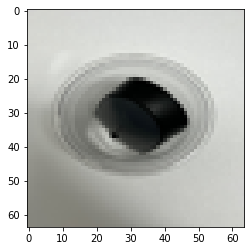

In [26]:
image1 = PIL.Image.open('test1.jpg')
re_img1 =image1.resize((64,64))
plt.imshow(re_img1)
re_img1 = tf(re_img1) # 해주면 image의 shape는 (3,64,64) 이된다
value = predict(re_img1)
if value == 0: #깨끗하면
    percent = predicts(re_img1) 
    print('percent: ',percent)
    percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
    print('percent_100',percent_100)
    
else: # 더러우면 
    percent = predicts(re_img1) 
    print('percent: ',percent)
    percent_100 = percent[0][0]*100
    print('percent_100',percent_100)

percent:  tensor([[1.0000]], grad_fn=<SigmoidBackward0>)
percent_100 tensor(99.9999, grad_fn=<MulBackward0>)


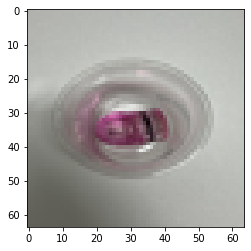

In [33]:
image2 = PIL.Image.open('test2.jpg')
re_img2 =image2.resize((64,64))
plt.imshow(re_img2)
re_img2 = tf(re_img2) # 해주면 image의 shape는 (3,64,64) 이된다
value = predict(re_img2)
if value == 0: #깨끗하면
    percent = predicts(re_img2) 
    print('percent: ',percent)
    percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
    print('percent_100',percent_100)
    
else: # 더러우면 
    percent = predicts(re_img2) 
    print('percent: ',percent)
    percent_100 = percent[0][0]*100
    print('percent_100',percent_100)

percent:  tensor([[1.]], grad_fn=<SigmoidBackward0>)
percent_100 tensor(100., grad_fn=<MulBackward0>)


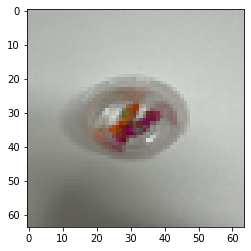

In [30]:
image3 = PIL.Image.open('test3.jpg')
re_img3 =image3.resize((64,64))
plt.imshow(re_img3)
re_img3 = tf(re_img3) # 해주면 image의 shape는 (3,64,64) 이된다
value = predict(re_img3)
if value == 0: #깨끗하면
    percent = predicts(re_img3) 
    print('percent: ',percent)
    percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
    print('percent_100',percent_100)
    
else: # 더러우면 
    percent = predicts(re_img3) 
    print('percent: ',percent)
    percent_100 = percent[0][0]*100
    print('percent_100',percent_100)

percent:  tensor([[1.]], grad_fn=<SigmoidBackward0>)
percent_100 tensor(100., grad_fn=<MulBackward0>)


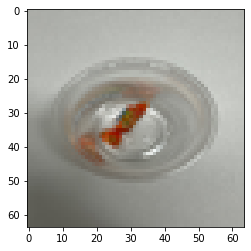

In [44]:
image4 = PIL.Image.open('./test_image/test4.jpg')
re_img4 =image4.resize((64,64))
plt.imshow(re_img4)
re_img4 = tf(re_img4) # 해주면 image의 shape는 (3,64,64) 이된다
value = predict(re_img4)
if value == 0: #깨끗하면
    percent = predicts(re_img4) 
    print('percent: ',percent)
    percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
    print('percent_100',percent_100)
    
else: # 더러우면 
    percent = predicts(re_img4) 
    print('percent: ',percent)
    percent_100 = percent[0][0]*100
    print('percent_100',percent_100)

percent:  tensor([[0.0056]], grad_fn=<SigmoidBackward0>)
percent_100 tensor(99.4433, grad_fn=<MulBackward0>)


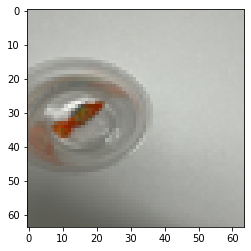

In [35]:
image5 = PIL.Image.open('test5.jpg')
re_img5 =image5.resize((64,64))
plt.imshow(re_img5)
re_img5 = tf(re_img5) # 해주면 image의 shape는 (3,64,64) 이된다
value = predict(re_img5)
if value == 0: #깨끗하면
    percent = predicts(re_img5) 
    print('percent: ',percent)
    percent_100 = (1 - percent[0][0])*100 #(깨끗한 경우에만 몇퍼센드인지)
    print('percent_100',percent_100)
    
else: # 더러우면 
    percent = predicts(re_img5) 
    print('percent: ',percent)
    percent_100 = percent[0][0]*100
    print('percent_100',percent_100)

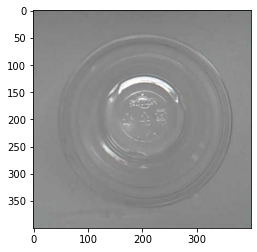

In [79]:
image5 = PIL.Image.open('cupimg 15 August 2022 15h 22m 00s.jpg')
area = (300,200,700,600)
crop_img = image5.crop(area)
#plt.imshow(image5)
plt.imshow(crop_img)

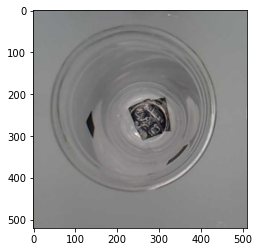

In [40]:
image5 = PIL.Image.open('cupimg 19 August 2022 10h 05m 32s.jpg')
area =  (220,80,730,600)
crop_img = image5.crop(area)
#plt.imshow(image5)
plt.imshow(crop_img)